In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Importing necessary library**

In [4]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.3 MB/s eta 0:00:0000:01
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

2024-04-09 17:37:33.523369: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 17:37:33.523488: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 17:37:33.660557: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Installing tensorflow**

**setting the image fixed size for training and intializing the batch size, channel and number of epochs**

In [6]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="<--enter your api key-->")
project = rf.workspace("shouldermri-0kxqo").project("shouldermri-ucegj")
version = project.version(1)
dataset = version.download("folder")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 34.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uninstalled cycler-0.12.1
  Attempting uninstall: certifi
    Found existing installation: certifi 2


Extracting Dataset Version Zip to ShoulderMRI-1 in folder:: 100%|██████████| 4833/4833 [00:00<00:00, 5882.77it/s]


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator()

In [8]:
Image_Size= 224
Batch_Size = 32
Channels=3
Epochs=50

**determining number of pics and classes**

In [9]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/working/ShoulderMRI-1/train",
    shuffle=True,
    image_size = (Image_Size,Image_Size),
    batch_size=Batch_Size
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/working/ShoulderMRI-1/test",
    shuffle=True,
    image_size = (Image_Size,Image_Size),
    batch_size=Batch_Size
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/working/ShoulderMRI-1/valid",
    shuffle=True,
    image_size = (Image_Size,Image_Size),
    batch_size=Batch_Size
)

Found 3376 files belonging to 2 classes.
Found 478 files belonging to 2 classes.
Found 968 files belonging to 2 classes.


**present class name**

In [10]:
class_names = train_data.class_names
class_names

['abnormal', 'normal']

In [11]:
for image_batch, label_batch in train_data.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 224, 224, 3)
[0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]


**trying out for the first image**

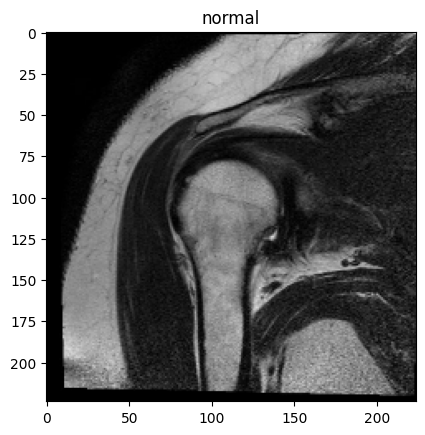

In [12]:
for image_batch, label_batch in train_data.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])

In [13]:
acc = []
model_list = []

In [14]:
n_classes = 2

In [15]:
from tensorflow.keras.applications import VGG19

input_shape = (Image_Size, Image_Size, Channels)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

model_vgg19 = models.Sequential([
    base_model,
    layers.GlobalMaxPooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
    
])

model_vgg19.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])


80134624/80134624 [==============================] - 2s 0us/step


In [16]:
history_vgg19 = model_vgg19.fit(train_data, validation_data=val_data, epochs=30)

Epoch 1/30


I0000 00:00:1712684367.236288     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


106/106 [==============================] - 52s 335ms/step - loss: 28.5722 - accuracy: 0.6431 - val_loss: 32106.5293 - val_accuracy: 0.6508
Epoch 2/30
106/106 [==============================] - 29s 268ms/step - loss: 0.6597 - accuracy: 0.6662 - val_loss: 2001.1063 - val_accuracy: 0.6508
Epoch 3/30
106/106 [==============================] - 29s 269ms/step - loss: 0.6364 - accuracy: 0.6709 - val_loss: 677.4399 - val_accuracy: 0.6488
Epoch 4/30
106/106 [==============================] - 29s 269ms/step - loss: 0.7421 - accuracy: 0.6567 - val_loss: 691.2803 - val_accuracy: 0.6529
Epoch 5/30
106/106 [==============================] - 29s 268ms/step - loss: 2.8474 - accuracy: 0.6040 - val_loss: 5464.1748 - val_accuracy: 0.6529
Epoch 6/30
106/106 [==============================] - 29s 269ms/step - loss: 0.6876 - accuracy: 0.6614 - val_loss: 1103.4015 - val_accuracy: 0.6529
Epoch 7/30
106/106 [==============================] - 29s 269ms/step - loss: 0.6375 - accuracy: 0.6712 - val_loss: 595.0740

In [24]:
train_score = model_vgg19.evaluate(train_data)
valid_score = model_vgg19.evaluate(val_data)
test_score = model_vgg19.evaluate(test_data)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 30)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 30)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

15/15 [==============================] - 1s 79ms/step - loss: 0.6680 - accuracy: 0.6381
Train Loss:  0.6376742720603943
Train Accuracy:  0.6712085604667664
------------------------------
Validation Loss:  809.8327026367188
Validation Accuracy:  0.6528925895690918
------------------------------
Test Loss:  0.6679825186729431
Test Accuracy:  0.6380752921104431


In [29]:
acc.append(test_score[1])
model_list.append("VGG19")
print(acc, model_list)

[0.6380752921104431] ['VGG19']


In [33]:
from tensorflow.keras.applications import ResNet101

input_shape = (Image_Size, Image_Size, Channels)
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)

model_resnet101 = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model_resnet101.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])


In [34]:
history_model_resnet101 = model_resnet101.fit(train_data, validation_data=val_data, epochs=30)

Epoch 1/30
106/106 [==============================] - 99s 340ms/step - loss: 2.2921 - accuracy: 0.6549 - val_loss: 13566.6660 - val_accuracy: 0.6229
Epoch 2/30
106/106 [==============================] - 34s 321ms/step - loss: 0.5888 - accuracy: 0.7085 - val_loss: 2.3426 - val_accuracy: 0.6467
Epoch 3/30
106/106 [==============================] - 34s 321ms/step - loss: 0.4962 - accuracy: 0.7577 - val_loss: 0.8274 - val_accuracy: 0.7169
Epoch 4/30
106/106 [==============================] - 34s 321ms/step - loss: 0.4187 - accuracy: 0.7912 - val_loss: 0.4339 - val_accuracy: 0.8182
Epoch 5/30
106/106 [==============================] - 34s 322ms/step - loss: 0.4438 - accuracy: 0.8288 - val_loss: 1.2335 - val_accuracy: 0.6529
Epoch 6/30
106/106 [==============================] - 34s 322ms/step - loss: 0.4076 - accuracy: 0.8172 - val_loss: 0.5272 - val_accuracy: 0.7200
Epoch 7/30
106/106 [==============================] - 34s 322ms/step - loss: 0.2924 - accuracy: 0.8759 - val_loss: 0.9004 - va

In [35]:
train_score = model_resnet101.evaluate(train_data)
valid_score = model_resnet101.evaluate(val_data)
test_score = model_resnet101.evaluate(test_data)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 30)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 30)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

15/15 [==============================] - 3s 178ms/step - loss: 2.4568 - accuracy: 0.7448
Train Loss:  1.6615954637527466
Train Accuracy:  0.8462677597999573
------------------------------
Validation Loss:  1.357527732849121
Validation Accuracy:  0.7489669322967529
------------------------------
Test Loss:  2.4568419456481934
Test Accuracy:  0.7447698712348938


In [36]:
print(acc, model_list)

[0.6380752921104431] ['VGG19']


In [37]:
acc.append(test_score[1])
model_list.append("ResNet101")
print(acc, model_list)

[0.6380752921104431, 0.7447698712348938] ['VGG19', 'ResNet101']


In [47]:
from tensorflow.keras.applications import EfficientNetB0

input_shape = (Image_Size, Image_Size, Channels)
n_classes = 2

densenet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

model_efficientnetb0 = models.Sequential([
    densenet_base,
    layers.GlobalMaxPooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model_efficientnetb0.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_max_pooling2d_3 (Gl  (None, 1280)              0         
 obalMaxPooling2D)                                               
                                                                 
 dense_12 (Dense)            (None, 256)               327936    
                                                                 
 dense_13 (Dense)            (None, 2)                 514       
                                                                 
Total params: 4378021 (16.70 MB)
Trainable params: 4335998 (16.54 MB)
Non-trainable params: 42023 (164.16 KB)
_________________________________________________________________


In [48]:
model_efficientnetb0.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])


In [ ]:
history_model_efficientnetb0 = model_efficientnetb0.fit(train_data, validation_data=val_data, epochs=30)

Epoch 1/30


2024-04-09 19:27:09.724184: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


106/106 [==============================] - 56s 238ms/step - loss: 1.1077 - accuracy: 0.7219 - val_loss: 0.6595 - val_accuracy: 0.7562
Epoch 2/30
106/106 [==============================] - 24s 224ms/step - loss: 0.3310 - accuracy: 0.8634 - val_loss: 0.4365 - val_accuracy: 0.8110
Epoch 3/30
106/106 [==============================] - 24s 224ms/step - loss: 0.1930 - accuracy: 0.9248 - val_loss: 0.5152 - val_accuracy: 0.8388
Epoch 4/30
106/106 [==============================] - 24s 224ms/step - loss: 0.1498 - accuracy: 0.9446 - val_loss: 0.4879 - val_accuracy: 0.8409
Epoch 5/30
106/106 [==============================] - 24s 223ms/step - loss: 0.1342 - accuracy: 0.9502 - val_loss: 0.5366 - val_accuracy: 0.8647
Epoch 6/30
106/106 [==============================] - 24s 223ms/step - loss: 0.0839 - accuracy: 0.9704 - val_loss: 0.5000 - val_accuracy: 0.8709
Epoch 7/30
106/106 [==============================] - 24s 223ms/step - loss: 0.1095 - accuracy: 0.9582 - val_loss: 0.4447 - val_accuracy: 0.8

In [50]:
history_model_efficientnetb0.history

{'loss': [1.107672929763794,
  0.33102652430534363,
  0.19304172694683075,
  0.14980870485305786,
  0.13418954610824585,
  0.08387359231710434,
  0.1094982922077179,
  0.07823417335748672,
  0.06942550092935562,
  0.05961649864912033,
  0.06501900404691696,
  0.05682847276329994,
  0.04666014015674591,
  0.049094051122665405,
  0.047538675367832184,
  0.05306076630949974,
  0.030447272583842278,
  0.03629666939377785,
  0.03462064266204834,
  0.030380871146917343,
  0.025679972022771835,
  0.02731303870677948,
  0.027516912668943405,
  0.041365984827280045,
  0.038466788828372955,
  0.03217233717441559,
  0.03126870468258858,
  0.039486754685640335,
  0.029301177710294724,
  0.030483422800898552],
 'accuracy': [0.7218601703643799,
  0.8634478449821472,
  0.924763023853302,
  0.9446089863777161,
  0.950236976146698,
  0.9703791737556458,
  0.9582346081733704,
  0.9721564054489136,
  0.9754146933555603,
  0.9777843356132507,
  0.9751184582710266,
  0.9807464480400085,
  0.983116090297699

In [51]:
train_score = model_efficientnetb0.evaluate(train_data)
valid_score = model_efficientnetb0.evaluate(val_data)
test_score = model_efficientnetb0.evaluate(test_data)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 30)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 30)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

15/15 [==============================] - 1s 44ms/step - loss: 0.4089 - accuracy: 0.8682
Train Loss:  0.0072507597506046295
Train Accuracy:  0.9991113543510437
------------------------------
Validation Loss:  0.5280885696411133
Validation Accuracy:  0.8842975497245789
------------------------------
Test Loss:  0.4088844954967499
Test Accuracy:  0.8682008385658264


In [52]:
acc.append(test_score[1])
model_list.append("EfficientNetB0")
print(acc, model_list)

[0.6380752921104431, 0.7447698712348938, 0.8682008385658264] ['VGG19', 'ResNet101', 'EfficientNetB0']


In [53]:
from tensorflow.keras.applications import EfficientNetB3

input_shape = (Image_Size, Image_Size, Channels)
n_classes = 2

densenet_base = EfficientNetB3(weights='imagenet', include_top=False, input_shape=input_shape)

model_efficientnetb3 = models.Sequential([
    densenet_base,
    layers.GlobalMaxPooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model_efficientnetb3.summary()


43941136/43941136 [==============================] - 1s 0us/step
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 7, 7, 1536)        10783535  
 )                                                               
                                                                 
 global_max_pooling2d_4 (Gl  (None, 1536)              0         
 obalMaxPooling2D)                                               
                                                                 
 dense_14 (Dense)            (None, 256)               393472    
                                                                 
 dense_15 (Dense)            (None, 2)                 514       
                                                                 
Total params: 11177521 (42.64 MB)
Trainable params: 11090218 (42.31 MB)
Non-trainable params: 87303 (341.03 KB)
_________

In [54]:
model_efficientnetb3.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])


In [55]:
history_model_efficientnetb3 = model_efficientnetb3.fit(train_data, validation_data=val_data, epochs=30)

Epoch 1/30


2024-04-09 19:43:50.363147: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


106/106 [==============================] - 106s 448ms/step - loss: 1.0562 - accuracy: 0.7310 - val_loss: 0.5153 - val_accuracy: 0.7727
Epoch 2/30
106/106 [==============================] - 43s 404ms/step - loss: 0.3112 - accuracy: 0.8646 - val_loss: 1.1904 - val_accuracy: 0.7469
Epoch 3/30
106/106 [==============================] - 43s 405ms/step - loss: 0.2064 - accuracy: 0.9188 - val_loss: 0.5778 - val_accuracy: 0.8585
Epoch 4/30
106/106 [==============================] - 43s 404ms/step - loss: 0.1526 - accuracy: 0.9402 - val_loss: 0.8261 - val_accuracy: 0.8223
Epoch 5/30
106/106 [==============================] - 43s 407ms/step - loss: 0.1356 - accuracy: 0.9476 - val_loss: 0.6478 - val_accuracy: 0.8326
Epoch 6/30
106/106 [==============================] - 43s 404ms/step - loss: 0.1118 - accuracy: 0.9594 - val_loss: 0.4302 - val_accuracy: 0.8626
Epoch 7/30
106/106 [==============================] - 43s 404ms/step - loss: 0.0751 - accuracy: 0.9725 - val_loss: 0.5484 - val_accuracy: 0.

In [57]:
train_score = model_efficientnetb3.evaluate(train_data)
valid_score = model_efficientnetb3.evaluate(val_data)
test_score = model_efficientnetb3.evaluate(test_data)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 30)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 30)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

15/15 [==============================] - 1s 74ms/step - loss: 0.7428 - accuracy: 0.8473
Train Loss:  0.06485840678215027
Train Accuracy:  0.9751184582710266
------------------------------
Validation Loss:  0.7772022485733032
Validation Accuracy:  0.8450413346290588
------------------------------
Test Loss:  0.7427544593811035
Test Accuracy:  0.8472803235054016


In [58]:
acc.append(test_score[1])
model_list.append("EfficientNetB3")
print(acc, model_list)

[0.6380752921104431, 0.7447698712348938, 0.8682008385658264, 0.8472803235054016] ['VGG19', 'ResNet101', 'EfficientNetB0', 'EfficientNetB3']


In [59]:
from tensorflow.keras.applications import MobileNetV2

input_shape = (Image_Size, Image_Size, Channels)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

model_mobilenetv2 = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model_mobilenetv2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])




9406464/9406464 [==============================] - 1s 0us/step


In [60]:
history_model_mobilenetv2 = model_mobilenetv2.fit(train_data, validation_data=val_data, epochs=30)

Epoch 1/30
106/106 [==============================] - 36s 119ms/step - loss: 1.3799 - accuracy: 0.6967 - val_loss: 5.0907 - val_accuracy: 0.6529
Epoch 2/30
106/106 [==============================] - 11s 97ms/step - loss: 0.4127 - accuracy: 0.8169 - val_loss: 4.5618 - val_accuracy: 0.6529
Epoch 3/30
106/106 [==============================] - 11s 98ms/step - loss: 0.2900 - accuracy: 0.8717 - val_loss: 2.2938 - val_accuracy: 0.6529
Epoch 4/30
106/106 [==============================] - 11s 98ms/step - loss: 0.2240 - accuracy: 0.9126 - val_loss: 1.0306 - val_accuracy: 0.7304
Epoch 5/30
106/106 [==============================] - 11s 97ms/step - loss: 0.1901 - accuracy: 0.9251 - val_loss: 1.4992 - val_accuracy: 0.7149
Epoch 6/30
106/106 [==============================] - 11s 97ms/step - loss: 0.2676 - accuracy: 0.8960 - val_loss: 0.8838 - val_accuracy: 0.7014
Epoch 7/30
106/106 [==============================] - 11s 98ms/step - loss: 0.1737 - accuracy: 0.9339 - val_loss: 0.6900 - val_accuracy

In [61]:
train_score = model_mobilenetv2.evaluate(train_data)
valid_score = model_mobilenetv2.evaluate(val_data)
test_score = model_mobilenetv2.evaluate(test_data)


print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 30)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 30)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


15/15 [==============================] - 1s 58ms/step - loss: 5.1681 - accuracy: 0.7050
Train Loss:  2.662111282348633
Train Accuracy:  0.7893957495689392
------------------------------
Validation Loss:  4.983127117156982
Validation Accuracy:  0.7221074104309082
------------------------------
Test Loss:  5.168118000030518
Test Accuracy:  0.7050209045410156


In [62]:
acc.append(test_score[1])
model_list.append("MobileNetV2")
print(acc, model_list)

[0.6380752921104431, 0.7447698712348938, 0.8682008385658264, 0.8472803235054016, 0.7050209045410156] ['VGG19', 'ResNet101', 'EfficientNetB0', 'EfficientNetB3', 'MobileNetV2']


**Predicting Labels for a Batch of Images**

In [63]:
from tensorflow.keras.applications import InceptionV3

input_shape = (Image_Size, Image_Size, Channels)
n_classes = 2

inceptionv3_base = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

model_inceptionv3 = models.Sequential([
    inceptionv3_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model_inceptionv3.summary()


87910968/87910968 [==============================] - 3s 0us/step
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_18 (Dense)            (None, 256)               524544    
                                                                 
 dense_19 (Dense)            (None, 2)                 514       
                                                                 
Total params: 22327842 (85.17 MB)
Trainable params: 22293410 (85.04 MB)
Non-trainable params: 34432 (134.50 KB)
_________________________________________________________________


In [64]:
model_inceptionv3.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])


In [65]:
history_model_inceptionv3 = model_inceptionv3.fit(train_data, validation_data=val_data, epochs=30)

Epoch 1/30
106/106 [==============================] - 61s 229ms/step - loss: 0.5870 - accuracy: 0.7121 - val_loss: 16.7017 - val_accuracy: 0.4163
Epoch 2/30
106/106 [==============================] - 17s 163ms/step - loss: 0.4157 - accuracy: 0.8178 - val_loss: 0.7006 - val_accuracy: 0.7696
Epoch 3/30
106/106 [==============================] - 18s 163ms/step - loss: 0.3263 - accuracy: 0.8637 - val_loss: 0.7140 - val_accuracy: 0.7552
Epoch 4/30
106/106 [==============================] - 17s 163ms/step - loss: 0.3128 - accuracy: 0.8711 - val_loss: 1.4012 - val_accuracy: 0.6973
Epoch 5/30
106/106 [==============================] - 17s 163ms/step - loss: 0.2594 - accuracy: 0.8943 - val_loss: 2.2570 - val_accuracy: 0.4432
Epoch 6/30
106/106 [==============================] - 17s 162ms/step - loss: 0.2124 - accuracy: 0.9185 - val_loss: 0.4137 - val_accuracy: 0.8409
Epoch 7/30
106/106 [==============================] - 17s 162ms/step - loss: 0.2025 - accuracy: 0.9200 - val_loss: 0.7469 - val_a

In [66]:
train_score = model_inceptionv3.evaluate(train_data)
valid_score = model_inceptionv3.evaluate(val_data)
test_score = model_inceptionv3.evaluate(test_data)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 30)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 30)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


15/15 [==============================] - 3s 180ms/step - loss: 1.5151 - accuracy: 0.8222
Train Loss:  0.17989163100719452
Train Accuracy:  0.9529028534889221
------------------------------
Validation Loss:  1.5552393198013306
Validation Accuracy:  0.8378099203109741
------------------------------
Test Loss:  1.5151002407073975
Test Accuracy:  0.8221757411956787


In [67]:
acc.append(test_score[1])
model_list.append("InceptionV3")
print(acc, model_list)



[0.6380752921104431, 0.7447698712348938, 0.8682008385658264, 0.8472803235054016, 0.7050209045410156, 0.8221757411956787] ['VGG19', 'ResNet101', 'EfficientNetB0', 'EfficientNetB3', 'MobileNetV2', 'InceptionV3']


In [68]:
from tensorflow.keras.applications import DenseNet121

input_shape = (Image_Size, Image_Size, Channels)
n_classes = 2

densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

model_densenet = models.Sequential([
    densenet_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model_densenet.summary()


29084464/29084464 [==============================] - 1s 0us/step
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten_4 (Flatten)         (None, 50176)             0         
                                                                 
 dense_20 (Dense)            (None, 256)               12845312  
                                                                 
 dense_21 (Dense)            (None, 2)                 514       
                                                                 
Total params: 19883330 (75.85 MB)
Trainable params: 19799682 (75.53 MB)
Non-trainable params: 83648 (326.75 KB)
_________________________________________________________________


In [69]:
model_densenet.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])


In [70]:
history_model_densenet = model_densenet.fit(train_data, validation_data=val_data, epochs=30)

Epoch 1/30
106/106 [==============================] - 96s 306ms/step - loss: 3.0291 - accuracy: 0.6351 - val_loss: 7843.8521 - val_accuracy: 0.6539
Epoch 2/30
106/106 [==============================] - 23s 213ms/step - loss: 0.9362 - accuracy: 0.6386 - val_loss: 5.1972 - val_accuracy: 0.5103
Epoch 3/30
106/106 [==============================] - 23s 214ms/step - loss: 0.5410 - accuracy: 0.7450 - val_loss: 1.1371 - val_accuracy: 0.7386
Epoch 4/30
106/106 [==============================] - 23s 213ms/step - loss: 0.4938 - accuracy: 0.7737 - val_loss: 0.5597 - val_accuracy: 0.7758
Epoch 5/30
106/106 [==============================] - 23s 213ms/step - loss: 0.4615 - accuracy: 0.7906 - val_loss: 0.5042 - val_accuracy: 0.7655
Epoch 6/30
106/106 [==============================] - 23s 214ms/step - loss: 0.3766 - accuracy: 0.8392 - val_loss: 0.4775 - val_accuracy: 0.7789
Epoch 7/30
106/106 [==============================] - 23s 213ms/step - loss: 0.4825 - accuracy: 0.7746 - val_loss: 2.8370 - val

In [71]:
train_score = model_densenet.evaluate(train_data)
valid_score = model_densenet.evaluate(val_data)
test_score = model_densenet.evaluate(test_data)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 30)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 30)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

15/15 [==============================] - 4s 253ms/step - loss: 0.5918 - accuracy: 0.8452
Train Loss:  0.06842584908008575
Train Accuracy:  0.974526047706604
------------------------------
Validation Loss:  0.6767797470092773
Validation Accuracy:  0.8398760557174683
------------------------------
Test Loss:  0.5917537212371826
Test Accuracy:  0.8451882600784302


In [72]:
acc.append(test_score[1])
model_list.append("DenseNet121")
print(acc, model_list)

[0.6380752921104431, 0.7447698712348938, 0.8682008385658264, 0.8472803235054016, 0.7050209045410156, 0.8221757411956787, 0.8451882600784302] ['VGG19', 'ResNet101', 'EfficientNetB0', 'EfficientNetB3', 'MobileNetV2', 'InceptionV3', 'DenseNet121']


In [73]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator()

In [74]:
gen_testing = datagen.flow_from_directory(
    "/kaggle/working/ShoulderMRI-1/test",
    target_size=(224, 224),
    batch_size=20
)

Found 478 images belonging to 2 classes.


In [75]:
from PIL import Image
y_actual_path = gen_testing.filepaths
y_actual = gen_testing.labels
from sklearn.metrics import accuracy_score

In [76]:
acc_test = []

In [77]:
y_pred = []
for image_path in y_actual_path:
    image = Image.open(image_path)
    img = image.resize((224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # Make predictions
    predictions = model_vgg19.predict(img_array)
    class_labels = ['Abnormal','Normal']
    score = tf.nn.softmax(predictions[0])
    max_index = np.array(predictions).argmax()
    target = class_labels[max_index]
    y_pred.append(max_index)

1/1 [==============================] - 0s 19ms/step


In [78]:
acc_test.append(accuracy_score(y_actual,y_pred))

In [79]:
acc_test

[0.37447698744769875]

In [80]:
y_pred = []
for image_path in y_actual_path:
    image = Image.open(image_path)
    img = image.resize((224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # Make predictions
    predictions = model_resnet101.predict(img_array)
    class_labels = ['Abnormal','Normal']
    score = tf.nn.softmax(predictions[0])
    max_index = np.array(predictions).argmax()
    target = class_labels[max_index]
    y_pred.append(max_index)
acc_test.append(accuracy_score(y_actual,y_pred))

1/1 [==============================] - 0s 27ms/step


In [82]:
y_pred = []
for image_path in y_actual_path:
    image = Image.open(image_path)
    img = image.resize((224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # Make predictions
    predictions = model_efficientnetb0.predict(img_array)
    class_labels = ['Abnormal','Normal']
    score = tf.nn.softmax(predictions[0])
    max_index = np.array(predictions).argmax()
    target = class_labels[max_index]
    y_pred.append(max_index)
acc_test.append(accuracy_score(y_actual,y_pred))

1/1 [==============================] - 0s 26ms/step


In [83]:
acc_test

[0.37447698744769875, 0.7426778242677824, 0.8765690376569037]

In [84]:
y_pred = []
for image_path in y_actual_path:
    image = Image.open(image_path)
    img = image.resize((224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # Make predictions
    predictions = model_efficientnetb3.predict(img_array)
    class_labels = ['Abnormal','Normal']
    score = tf.nn.softmax(predictions[0])
    max_index = np.array(predictions).argmax()
    target = class_labels[max_index]
    y_pred.append(max_index)
acc_test.append(accuracy_score(y_actual,y_pred))
acc_test

1/1 [==============================] - 0s 31ms/step


[0.37447698744769875,
 0.7426778242677824,
 0.8765690376569037,
 0.8347280334728033]

In [85]:
y_pred = []
for image_path in y_actual_path:
    image = Image.open(image_path)
    img = image.resize((224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # Make predictions
    predictions = model_mobilenetv2.predict(img_array)
    class_labels = ['Abnormal','Normal']
    score = tf.nn.softmax(predictions[0])
    max_index = np.array(predictions).argmax()
    target = class_labels[max_index]
    y_pred.append(max_index)
acc_test.append(accuracy_score(y_actual,y_pred))
acc_test

1/1 [==============================] - 0s 23ms/step


[0.37447698744769875,
 0.7426778242677824,
 0.8765690376569037,
 0.8347280334728033,
 0.7050209205020921]

In [86]:
y_pred = []
for image_path in y_actual_path:
    image = Image.open(image_path)
    img = image.resize((224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # Make predictions
    predictions = model_inceptionv3.predict(img_array)
    class_labels = ['Abnormal','Normal']
    score = tf.nn.softmax(predictions[0])
    max_index = np.array(predictions).argmax()
    target = class_labels[max_index]
    y_pred.append(max_index)
acc_test.append(accuracy_score(y_actual,y_pred))

1/1 [==============================] - 0s 27ms/step


In [87]:
y_pred = []
for image_path in y_actual_path:
    image = Image.open(image_path)
    img = image.resize((224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # Make predictions
    predictions = model_densenet.predict(img_array)
    class_labels = ['Abnormal','Normal']
    score = tf.nn.softmax(predictions[0])
    max_index = np.array(predictions).argmax()
    target = class_labels[max_index]
    y_pred.append(max_index)
acc_test.append(accuracy_score(y_actual,y_pred))
acc_test

1/1 [==============================] - 0s 31ms/step


[0.37447698744769875,
 0.7426778242677824,
 0.8765690376569037,
 0.8347280334728033,
 0.7050209205020921,
 0.8138075313807531,
 0.8326359832635983]

In [88]:
acc_test

[0.37447698744769875,
 0.7426778242677824,
 0.8765690376569037,
 0.8347280334728033,
 0.7050209205020921,
 0.8138075313807531,
 0.8326359832635983]

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


<Axes: title={'center': 'Accuracy Comparison'}, xlabel='Accuracy', ylabel='Algorithm'>

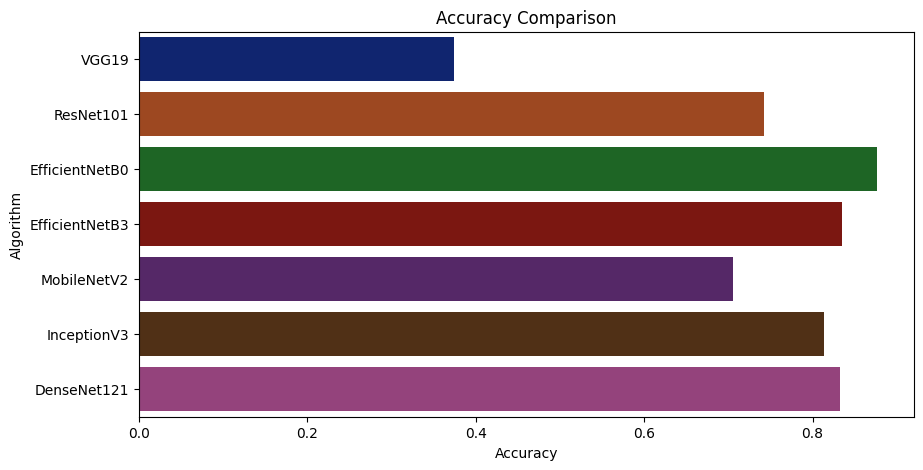

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=[10,5],dpi = 100)
plt.title('Accuracy Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Algorithm')
sns.barplot(x = acc_test,y = model_list,palette='dark')

In [94]:
accuracy_models = dict(zip(model_list, acc_test))
for k, v in accuracy_models.items():
    print (k, '-->', v)
     

VGG19 --> 0.37447698744769875
ResNet101 --> 0.7426778242677824
EfficientNetB0 --> 0.8765690376569037
EfficientNetB3 --> 0.8347280334728033
MobileNetV2 --> 0.7050209205020921
InceptionV3 --> 0.8138075313807531
DenseNet121 --> 0.8326359832635983


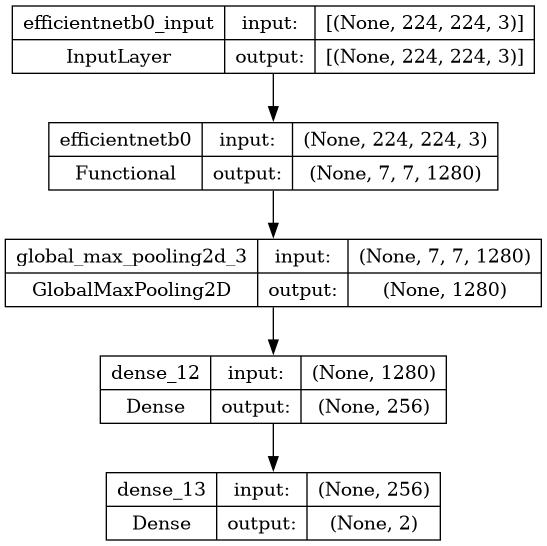

In [95]:
from tensorflow.keras.utils import plot_model
plot_model(model_efficientnetb0, show_shapes=True, to_file='cnn_model.png')

In [96]:
import matplotlib.pyplot as plt

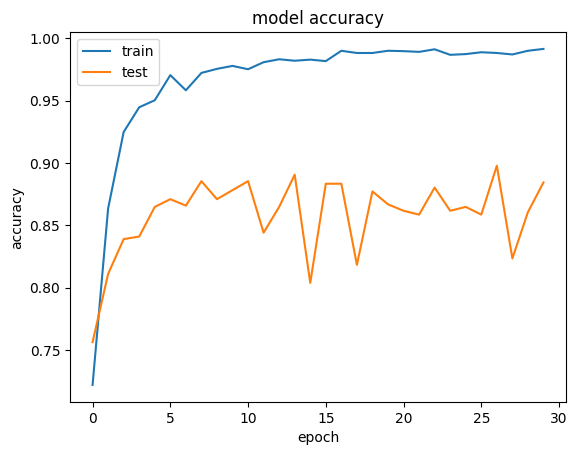

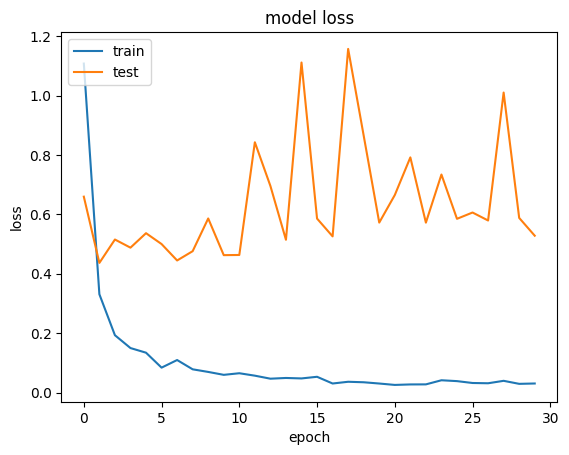

In [97]:
plt.plot(history_model_efficientnetb0.history['accuracy'])
plt.plot(history_model_efficientnetb0.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_model_efficientnetb0.history['loss'])
plt.plot(history_model_efficientnetb0.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [98]:
y_pred = []
for image_path in y_actual_path:
    image = Image.open(image_path)
    img = image.resize((224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # Make predictions
    predictions = model_efficientnetb0.predict(img_array)
    class_labels = ['Abnormal','Normal']
    score = tf.nn.softmax(predictions[0])
    max_index = np.array(predictions).argmax()
    target = class_labels[max_index]
    y_pred.append(max_index)

1/1 [==============================] - 0s 26ms/step


In [99]:
from sklearn.metrics import classification_report
print(classification_report(y_actual, y_pred,digits=4, target_names=['Abnormal', 'Normal']))

              precision    recall  f1-score   support

    Abnormal     0.8639    0.9574    0.9082       305
      Normal     0.9071    0.7341    0.8115       173

    accuracy                         0.8766       478
   macro avg     0.8855    0.8457    0.8599       478
weighted avg     0.8796    0.8766    0.8732       478



In [100]:
from sklearn.metrics import confusion_matrix


result = confusion_matrix(y_actual, y_pred)

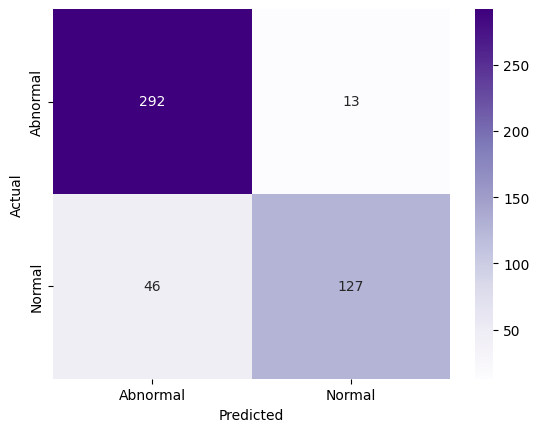

In [101]:
import pandas as pd
import seaborn as sns
label_names= ["Abnormal","Normal"]
df_cm = pd.DataFrame(result, columns=label_names, index=label_names)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Purples", annot=True, fmt='.0f'); # font size


In [102]:
model_efficientnetb0.save("model_8766.h5")

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


**Image Prediction Function Using the Model**

In [103]:
def pred(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [104]:
from tensorflow.keras.models import load_model

In [105]:
test_model = load_model('/kaggle/working/model_8766.h5')

# Show the model architecture
test_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_max_pooling2d_3 (Gl  (None, 1280)              0         
 obalMaxPooling2D)                                               
                                                                 
 dense_12 (Dense)            (None, 256)               327936    
                                                                 
 dense_13 (Dense)            (None, 2)                 514       
                                                                 
Total params: 4378021 (16.70 MB)
Trainable params: 4335998 (16.54 MB)
Non-trainable params: 42023 (164.16 KB)
_________________________________________________________________


In [106]:
train_score = test_model.evaluate(train_data)
valid_score = test_model.evaluate(val_data)
test_score = test_model.evaluate(test_data)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 30)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 30)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

15/15 [==============================] - 1s 44ms/step - loss: 0.4089 - accuracy: 0.8682
Train Loss:  0.007250759284943342
Train Accuracy:  0.9991113543510437
------------------------------
Validation Loss:  0.5280886292457581
Validation Accuracy:  0.8842975497245789
------------------------------
Test Loss:  0.4088844656944275
Test Accuracy:  0.8682008385658264


In [107]:
y_pred = []
for image_path in y_actual_path:
    image = Image.open(image_path)
    img = image.resize((224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # Make predictions
    predictions = test_model.predict(img_array)
    class_labels = ['Abnormal','Normal']
    score = tf.nn.softmax(predictions[0])
    max_index = np.array(predictions).argmax()
    target = class_labels[max_index]
    y_pred.append(max_index)

1/1 [==============================] - 0s 26ms/step


In [108]:
print(classification_report(y_pred,y_actual, digits=4))

              precision    recall  f1-score   support

           0     0.9574    0.8639    0.9082       338
           1     0.7341    0.9071    0.8115       140

    accuracy                         0.8766       478
   macro avg     0.8457    0.8855    0.8599       478
weighted avg     0.8920    0.8766    0.8799       478

